
# About the dataset



##### The California Housing data set appeared in a 1997 paper titled Sparse Spatial Autoregressions, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

##### The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

##### These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#####What's more, we also learn that all the block groups have zero entries for the independent and dependent variables have been excluded from the data.

#####The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

In [1]:
#install the Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

import findspark
findspark.init()

In [2]:
# import all necessary libraries and modules

import os
import pandas as pd
import numpy as np

In [3]:
# pyspark libraries and functions
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# import python visualization libraries

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# create the spark session

In [6]:
spark = SparkSession.builder.master('local[2]').appName('California-Housing-Linear-Regression').getOrCreate()

In [7]:
#lets see what does that spark specification show
spark

In [8]:
# lets create spark context 
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=California-Housing-Linear-Regression>

In [9]:
# lets also create the sql context

sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [10]:
# unzip the file 
from zipfile import ZipFile
file_name = "cal_housing.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [11]:
file_name

'cal_housing.zip'

In [12]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [13]:
# load cal_housing dateset

housing_df = spark.read.csv(path='cal_housing.data', schema=schema).cache()

In [14]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [15]:
# show the fields of the data 

housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [16]:
# now lets see the schema now
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



# Data Exploration

In [17]:
# lets see a sample of it 
housing_df.select('medinc', 'totrooms').show(15)

+------+--------+
|medinc|totrooms|
+------+--------+
|8.3252|   880.0|
|8.3014|  7099.0|
|7.2574|  1467.0|
|5.6431|  1274.0|
|3.8462|  1627.0|
|4.0368|   919.0|
|3.6591|  2535.0|
|  3.12|  3104.0|
|2.0804|  2555.0|
|3.6912|  3549.0|
|3.2031|  2202.0|
|3.2705|  3503.0|
| 3.075|  2491.0|
|2.6736|   696.0|
|1.9167|  2643.0|
+------+--------+
only showing top 15 rows



In [18]:
# show the grouping by medage

med_df = housing_df.groupBy('medage').count().sort('medage', ascending=False)
med_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



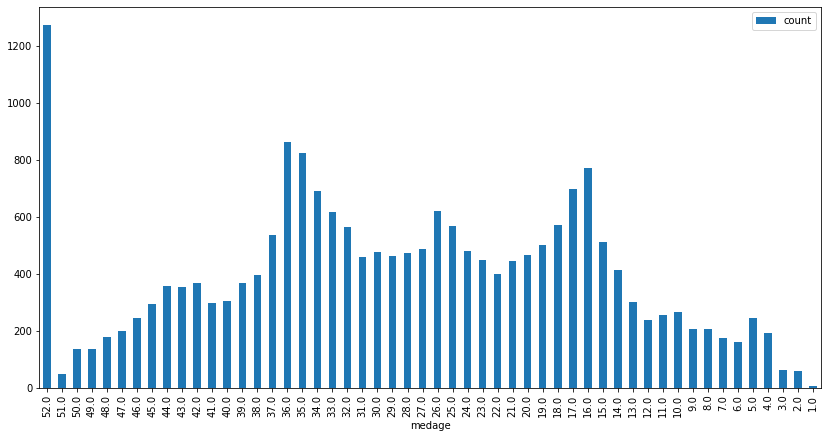

In [19]:
# visualize the medage distribution

med_df.toPandas().plot.bar(x='medage', figsize=(14, 7))



##### the above bar graph shows that most of the people at their youth age, there are also considerable amount of people who are senoirs. 

# Summary of the dataset

In [20]:
housing_df.describe().select("summary",
                             F.round("medage", 4).alias("medage"),
                             F.round("totrooms", 4).alias("totrooms"),
                             F.round("totbdrms", 4).alias("totbdrms"),
                             F.round("pop", 4).alias("pop"),
                             F.round("houshlds", 4).alias("houshlds"),
                             F.round("medinc", 4).alias("medinc"),
                             F.round("medhv", 4).alias("medhv")).show()

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



##### the summary shows that almost all of the numerical values have a wide range between min and max values. This indicates that our data would need normalization before we proceed with building the model

# Preprocessing

### Things we should consider before we proceed with preprocessing

###### All the missing values are handled
###### we shall definitely normalize our data as we have seen it from the previouse graph that there big range between the values
###### The dependent variable medhv values are large values and it should be normalized

In [21]:
# lets adjust the medhv by dividing 100,000

housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [22]:
housing_df.show(3)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 3 rows



# Feature Engineering

In [23]:
# again see the columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [24]:
# adding new columns to create new columns

housing_df = (housing_df.withColumn('rmsperhh', F.round(col('totrooms')/col("houshlds"), 2)).withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2)).withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"),2)))

In [25]:
# check the results
housing_df.show(3)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 3 rows



##### Now we can select out columns that are actually to be used for the creating the model 

In [26]:
# use the select to select the columns we need for the next process

housing_df = housing_df.select("medhv",
                               "totbdrms",
                               "pop",
                               "houshlds",
                               "medinc",
                               "rmsperhh",
                               "popperhh",
                               "bdrmsperrm")

# Feature Extraction

In [27]:
# lets normalize all the features now

selected_cols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

In [28]:
# now we will put them in feature columns
assembler = VectorAssembler(inputCols=selected_cols, outputCol= "features")
assembler_df = assembler.transform(housing_df)

In [29]:
assembler_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


##### the fatures are in Dense Vector

# Standardazation

######Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":

In [30]:
# initialization the satndatdScaler

standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [31]:
# Fit the DataFrame to the scaler
scaled_df = standard_scaler.fit(assembler_df).transform(assembler_df)

In [32]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

# Building the ML model

######we first need to split the data into training and test sets. Luckily, this is no issue with the randomSplit() method:

In [33]:
# Split the data into train and test sets
train_data, test_date = scaled_df.randomSplit([0.8, 0.2], seed = rnd_seed)


In [34]:
# lets check the train and test data
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

In [35]:
Lr = (LinearRegression(featuresCol='features_scaled', labelCol='medhv', predictionCol='predmedhv', maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [36]:
# Fit the data to the model
linearModel = Lr.fit(train_data)

#Evaluating the model

In [37]:
# lets check the coefficients 
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [40]:
selected_cols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [42]:
intercept = linearModel.intercept
intercept

1.0013833516596085

In [44]:
coeff_df = pd.DataFrame({"features":["intercept"]+selected_cols, "Co-efficients":
                         np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})

coeff_df = coeff_df[["features", "Co-efficients"]]


In [45]:
coeff_df

,features,Co-efficients
0,intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


# Predictions

In [47]:
# Generate predictions
predictions = linearModel.transform(test_date)

In [48]:
predictions.show()

+-------+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|  medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|         predmedhv|
+-------+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|0.14999|    28.0|  18.0|     8.0| 0.536|   12.25|    2.25|      0.29|[28.0,18.0,8.0,0....|[0.06646917315187...|  1.14982901467337|
|  0.225|   451.0|1230.0|   375.0|1.0918|    2.25|    3.28|      0.53|[451.0,1230.0,375...|[1.07062846755345...|1.3037582901805782|
|  0.225|  1743.0|6835.0|  1439.0|2.7138|    6.93|    4.75|      0.17|[1743.0,6835.0,14...|[4.13770602870438...| 1.752972574315186|
|  0.269|   543.0|1423.0|   482.0|2.1955|     5.7|    2.95|       0.2|[543.0,1423.0,482...|[1.28902717933819...|1.6094289295308724|
|  0.344|   121.0| 530.0|   115.0|2.1458|    3.08|    4.61|      0.34|[121.0

In [49]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [50]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
|1.2917940087238426|  0.367|
|1.8668547795751218|  0.375|
| 1.369423339785637|  0.394|
|1.5305533439120043|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043998|  0.417|
| 1.229923204690587|  0.425|
|1.4841640700933143|  0.425|
|1.3510338217435218|   0.43|
|1.2619110212709588|  0.436|
|1.3350814464678744|   0.44|
|1.4832778453641755|   0.44|
|1.4337313361080328|  0.444|
|1.3691187093204966|  0.445|
|  1.47521855868216|  0.446|
+------------------+-------+
only showing top 20 rows



# Metrics

##### lets see how our model is performinng using RMSE, R2 and MAE

In [51]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8819852045268861


In [52]:
#MAE
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6782895319917991


In [53]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.4180854895364573


#####The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.



######The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

###Using the RegressionEvaluator from pyspark.ml package:

In [55]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')

print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8677342923034236


In [56]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')

print("MAE: {0}".format(evaluator.evaluate(predandlabels)))


MAE: 0.6736097745764633


In [57]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')

print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.42517112885139363


###Using the RegressionMetrics from pyspark.mllib package:

In [58]:
# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.8677342923034236


In [59]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6736097745764633


In [60]:
print("R2: {0}".format(metrics.r2))

R2: 0.42517112885139363


#####There's definitely some improvements needed to our model! If we want to continue with this model, we can play around with the parameters that we passed to our model, the variables that we included in our original DataFrame.